Here we will test parameter recovery and model comparison for several models applied to the temporal reversal learning task.

In [1]:
import torch
torch.set_default_dtype(torch.float64)
from torch import ones, zeros, tensor

import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/temp_rev_learn')])

Lets start by simulating behavioral data for the temporal reversal learning.

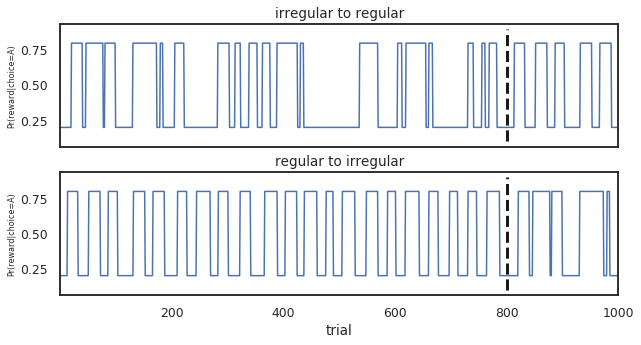

In [2]:
# load stimuli (trial offers, advices, and reliability of advices)
sns.set(context='talk', style = 'white', color_codes = True, font_scale=.75)
data = io.loadmat('pilot/states_and_rewards.mat')
Sirr = data['irregular']['S'][0, 0][:, 0] - 1
Oirr = data['irregular']['R'][0, 0]
Sreg = data['regular']['S'][0, 0][:, 0] - 1
Oreg = data['regular']['R'][0, 0]

# plot temporal structure of reversal in two conditions
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True, sharey=True)
ax[0].plot(.6*Sirr + .2, lw=1.5);
ax[1].plot(.6*Sreg + .2, lw=1.5);
ax[0].vlines(800, .1, .9, 'k', linestyle='--', lw = 3)
ax[1].vlines(800, .1, .9, 'k', linestyle='--', lw = 3)
ax[0].set_ylabel('Pr(reward|choice=A)', fontsize=8)
ax[1].set_xlabel('trial')
ax[0].set_title('irregular to regular')
ax[1].set_ylabel('Pr(reward|choice=A)', fontsize=8)
ax[1].set_title('regular to irregular')
ax[0].set_xlim([1, 1000]);

fig.savefig('reversal_schedule.svg', dpi=600)

Sirr = torch.from_numpy(Sirr)
Oirr = torch.from_numpy(Oirr)
Sreg = torch.from_numpy(Sreg)
Oreg = torch.from_numpy(Oreg)

In [3]:
blocks = 1 # number of blocks
nsub = 50  # number of subjects
trials = 1000  # number of samples

from befit.tasks import TempRevLearn
from befit.simulate import Simulator
from befit.agents import RLTempRevLearn, BayesTempRevLearn

torch.manual_seed(12345)

rewards = zeros(blocks, trials, nsub, 2)
rewards[..., :nsub//2, :] = Oreg.reshape(1, trials, 1, 2).repeat(1, 1, nsub//2, 1)
rewards[..., nsub//2:, :] = Oirr.reshape(1, trials, 1, 2).repeat(1, 1, nsub//2, 1)
rewards = ((rewards + 1)/2).long()

offers = zeros(blocks, trials, nsub, dtype=torch.long)

states = zeros(blocks, trials, nsub)
states[..., :nsub//2] = Sreg.reshape(1, trials, 1).repeat(1, 1, nsub//2)
states[..., nsub//2:] = Sirr.reshape(1, trials, 1).repeat(1, 1, nsub//2)
states = states.long()

stimuli = {'states': states, 
           'rewards': rewards, 
           'offers': offers}

temprev1 = TempRevLearn(stimuli, nsub=nsub)

# rl agent
rl_agent = RLTempRevLearn(runs=nsub, trials=trials)
trans_pars1 = torch.distributions.Normal(tensor([-1., 0., 1., 0.]), 1.).sample((nsub,))
rl_agent.set_parameters(trans_pars1)



# bayes agent
edhmm_agent = BayesTempRevLearn(runs=nsub, trials=trials)
trans_pars2 = torch.stack([torch.distributions.Normal(tensor([0., -2, 2., -.25, 0., 0., 0.]), .1).sample((nsub//2,)),
                           torch.distributions.Normal(tensor([0, 1., 2., -.25, 0., 0., 0.]), .1).sample((nsub//2,))], 
                          0).reshape(nsub, -1)

trans_pars2[:, -3:] = 0.
edhmm_agent.set_parameters(trans_pars2)

temprev2 = TempRevLearn(stimuli, nsub=nsub)


sim = Simulator([temprev1, temprev2], [rl_agent, edhmm_agent], runs=nsub, trials=trials)
sim.simulate_experiment()

stimuli, responses  = sim.format_stimuli_and_responses()

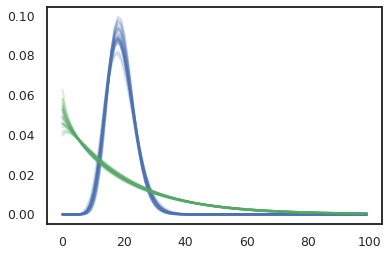

In [4]:
# plot priors over durations
plt.plot(edhmm_agent.pd.numpy()[:nsub//2].T, 'b', alpha=.2);
plt.plot(edhmm_agent.pd.numpy()[nsub//2:].T, 'g', alpha=.2);

## Plot behaviour

In [5]:
def get_reversal_statistics(responses, corrects, states, nsub, delta=200):
    trials = len(states)
    
    A = responses.T == 2
    C = corrects.T
    
    reversal = np.abs(np.diff(states.flatten())).astype(bool)
    trials = np.arange(1, trials)[reversal]
    perf = {}
    expl = {}
    for t in trials:
        block = np.long(np.floor(t/delta))
        perf.setdefault(block, [])
        perf[block].append(np.nanmean(C[:,t-10:t+10], 0))
        
        expl.setdefault(block, [])
        expl[block].append(np.nanmean(A[:,t-10:t+10], 0))
    
    return perf, expl

def plotting(responses, corrects, states):
    sns.set_palette('Set2', 8)
    fig1, ax1 = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
    fig2, ax2 = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
    fig1.tight_layout()
    fig2.tight_layout()
    
    t = np.arange(-10, 10)
    title = ['regular->irregular', 'irregular->regular']
    for i in range(2):
        perf, expl = get_reversal_statistics(responses[i], corrects[i], states[i], nsub//2)
        for block in range(5):
            ax1[i].plot(t, np.mean(np.vstack(perf[block]), 0), label=block+1)
            ax2[i].plot(t, np.mean(np.vstack(expl[block]), 0), label=block+1)
        ax1[i].vlines(0, .0, 1., 'k', linestyle='--', lw=2)
        ax2[i].vlines(0, .0, .5, 'k', linestyle='--', lw=2)

        ax1[i].set_xlabel('relative trial number')
        ax2[i].set_xlabel('relative trial number')
        
        ax1[i].set_title(title[i])
        
    ax1[0].set_ylabel('performance')
    ax2[0].set_ylabel('Pr(choice=explore)')
    ax1[0].legend(title='block')

In [6]:
res1 = responses['pair_0']
res2 = responses['pair_1']

# get correct responses
corrects1 = (states == res1).float()  
corrects1[res1 == 2] = np.nan
corrects1 = corrects1[0].numpy()

corrects2 = (states == res2).float()  
corrects2[res2 == 2] = np.nan
corrects2 = corrects2[0].numpy()

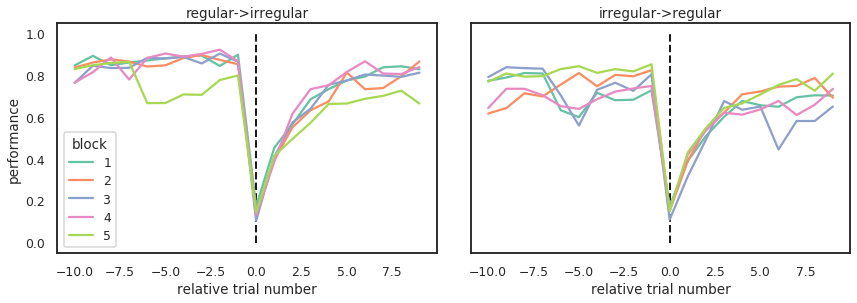

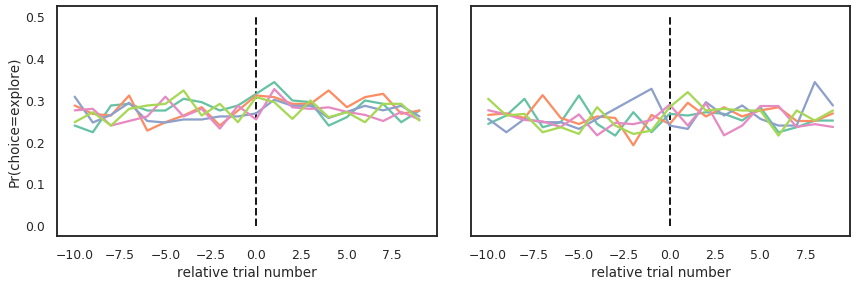

In [7]:
# plot behavior of the RL agent
plotting([res1[0, :, :nsub//2], res1[0, :, nsub//2:]], 
         [corrects1[..., :nsub//2], corrects1[..., nsub//2:]], 
         [Sreg, Sirr])

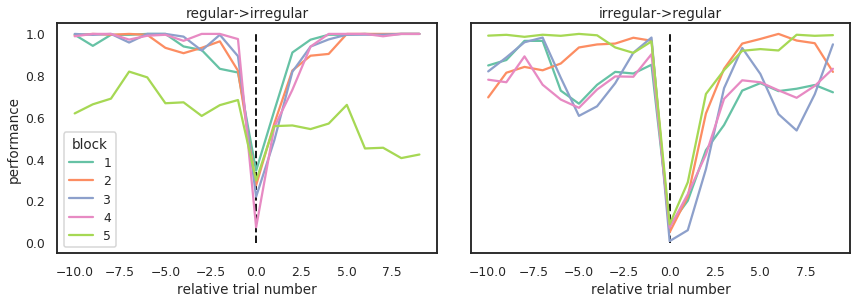

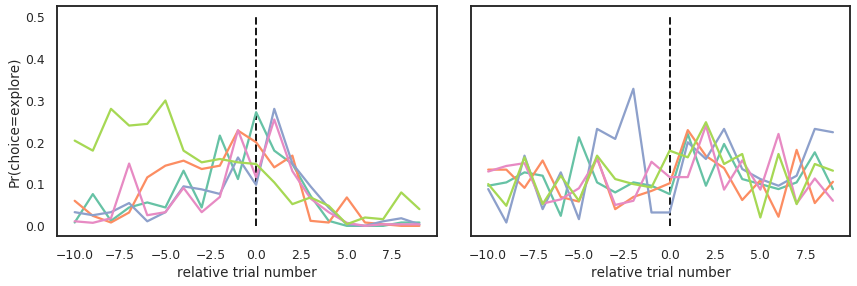

In [8]:
# plot behavior of the EDHMM agent
# figs = plotting(res2, states)
plotting([res2[0, :, :nsub//2], res2[0, :, nsub//2:]], 
         [corrects2[..., :nsub//2], corrects2[..., nsub//2:]], 
         [Sreg, Sirr])

## Fit simulated behaviour

In [9]:
from befit.inference import Horseshoe, NormalGamma, NormalGammaHierarch
from time import time
torch.manual_seed(time());

fit RL agent to simulated data

In [8]:
T1 = 0
T2 = 200

offers1 = sim1.stimuli['offers'][:, T1:T2]
outcomes1 = sim1.stimuli['outcomes'][:, T1:T2]
mask1 = torch.ones_like(offers1, dtype=torch.bool)

stimuli = {'offers': offers1,
           'outcomes': outcomes1,
           'mask': mask1.double()}
mask = mask1.clone()
mask[:, :50] = 0

responses = sim1.responses[:, T1:T2]
rl_agent = RLTempRevLearn(runs=nsub, trials=T2-T1)
rl_agent.set_parameters()

rl_infer = Horseshoe(rl_agent, stimuli, responses, mask=mask)
rl_infer.infer_posterior(iter_steps=500)

Mean ELBO 9318.61: 100%|██████████| 500/500 [25:25<00:00,  2.57s/it]


Compute fit quality and plot posterior estimates from a hierarchical parameteric model

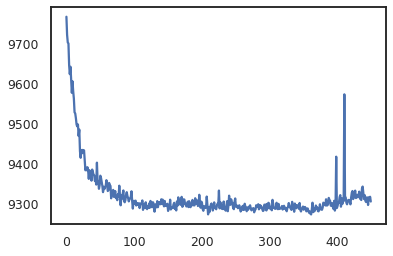

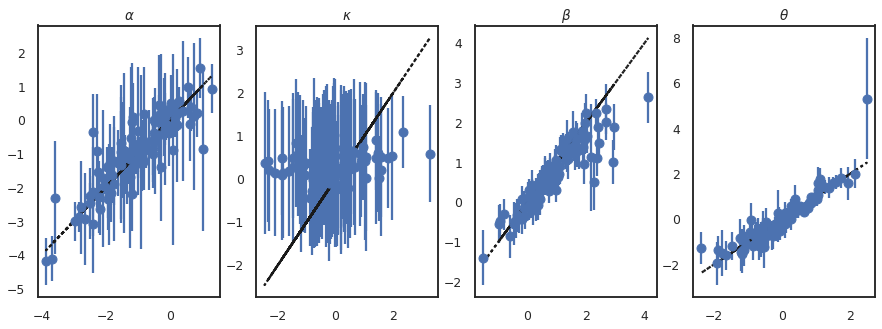

In [9]:
labels = [r'$\alpha$', r'$\kappa$', r'$\beta$', r'$\theta$']
tp_df = rl_infer.sample_posterior(labels, n_samples=1000)

rl_pars_mean = tp_df[0].groupby('subject').mean()
rl_pars_std = tp_df[0].groupby('subject').std()

#plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.figure()    
plt.plot(rl_infer.loss[-450:])

fig, axes = plt.subplots(1, len(labels), figsize=(15, 5)) 
for i, l in enumerate(labels):
    axes[i].errorbar(trans_pars1[:, i].numpy(), 
                     rl_pars_mean[l], 
                     yerr=2*rl_pars_std[l], 
                    linestyle='',
                    marker='o')
    axes[i].plot(trans_pars1[:, i].numpy(), trans_pars1[:, i].numpy(), 'k:')
    axes[i].set_title(l)

In [11]:
from pyro import param

print(param('m'))
print(param('lam'))

tensor([-0.9533,  0.3485,  0.7461,  0.0163], requires_grad=True)
tensor([1.0360], grad_fn=<AddBackward0>)


fit ED-HMM agent to simulated data

In [10]:
# fit to the condition with regular reversals
T1 = 600
T2 = 800

offers2 = stimuli['pair_1']['offers'][:, T1:T2, nsub//2:]
outcomes2 = stimuli['pair_1']['outcomes'][:, T1:T2, nsub//2:]
mask2 = torch.ones_like(offers2, dtype=torch.bool)

stml = {'offers': offers2,
        'outcomes': outcomes2,
        'mask': mask2.double()}
mask = mask2.clone()

responses = res2[:, T1:T2, nsub//2:]
edhmm_agent = BayesTempRevLearn(runs=nsub//2, trials=T2-T1)
edhmm_agent.set_parameters()

In [11]:
vals = torch.zeros(nsub//2, 3)
fixed_params = {'labels': [4, 5, 6],
                'values': vals}

edhmm_infer = NormalGamma(edhmm_agent, stml, responses, mask=mask, fixed_params=fixed_params)
edhmm_infer.infer_posterior(iter_steps=300)

Mean ELBO 1146.22: 100%|██████████| 300/300 [4:08:46<00:00, 36.31s/it]  


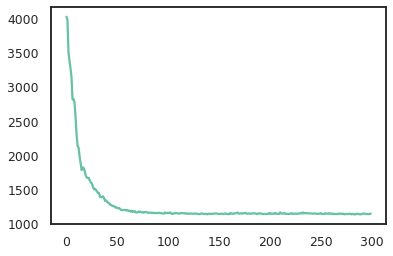

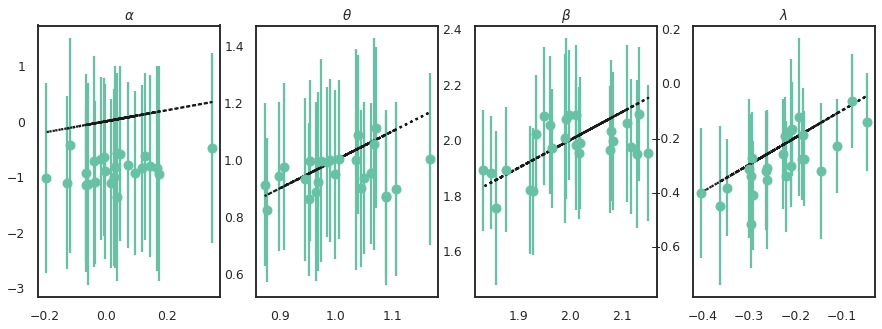

In [13]:
labels = [r'$\alpha$', r'$\theta$', r'$\beta$', r'$\lambda$']#, r'$c0$', r'$p_H$', r'$p_L$']
edhmm_tp_df = edhmm_infer.sample_posterior(labels, n_samples=1000)

trans_pars_edhmm = edhmm_tp_df[0].melt(id_vars='subject', var_name='parameter')

edhmm_pars_mean = edhmm_tp_df[0].groupby('subject').mean()
edhmm_pars_std = edhmm_tp_df[0].groupby('subject').std()

#plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.figure()    
plt.plot(edhmm_infer.loss[-400:])

fig, axes = plt.subplots(1, len(labels), figsize=(15, 5))
locs = [0, 1, 2, 3, 4, 5, 6]
for i, l in enumerate(labels):
    axes[i].errorbar(trans_pars2[nsub//2:, locs[i]].numpy(), 
                     edhmm_pars_mean[l], 
                     yerr=2*edhmm_pars_std[l], 
                    linestyle='',
                    marker='o')
    axes[i].plot(trans_pars2[nsub//2:, locs[i]].numpy(), trans_pars2[nsub//2:, locs[i]].numpy(), 'k:')
    axes[i].set_title(l)

In [ ]:
# fit to the condition with irregular reversals
T1 = 0
T2 = 200

offers2 = sim2.stimuli['offers'][:, T1:T2, nsub//2:]
outcomes2 = sim2.stimuli['outcomes'][:, T1:T2, nsub//2:]
mask2 = torch.ones_like(offers2, dtype=torch.bool)

stimuli = {'offers': offers2,
           'outcomes': outcomes2,
           'mask': mask2.double()}
mask = mask2.clone()

responses = sim2.responses[:, T1:T2, nsub//2:]
edhmm_agent = BayesTempRevLearn(runs=nsub//2, trials=T2-T1)
edhmm_agent.set_parameters()

edhmm_infer = Horseshoe(edhmm_agent, stimuli, responses, mask=mask)
edhmm_infer.infer_posterior(iter_steps=500)

Mean ELBO 1450.29:  30%|██▉       | 149/500 [1:10:31<2:34:03, 26.34s/it]

In [ ]:
labels = [r'$\delta$', r'$\rho$', r'$\beta$', r'$\lambda$', r'$c0$', r'$p_H$', r'$p_L$']
edhmm_tp_df = edhmm_infer.sample_posterior(labels, n_samples=1000)

trans_pars_edhmm = edhmm_tp_df[0].melt(id_vars='subject', var_name='parameter')

edhmm_pars_mean = edhmm_tp_df[0].groupby('subject').mean()
edhmm_pars_std = edhmm_tp_df[0].groupby('subject').std()

#plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.figure()    
plt.plot(edhmm_infer.loss[-150:])

fig, axes = plt.subplots(1, len(labels), figsize=(15, 5))
locs = [0, 1, 2, 3, 4, 5, 6]
for i, l in enumerate(labels):
    axes[i].errorbar(trans_pars2[:nsub//2, locs[i]].numpy(), 
                     edhmm_pars_mean[l], 
                     yerr=2*edhmm_pars_std[l], 
                    linestyle='',
                    marker='o')
    axes[i].plot(trans_pars2[:nsub//2, locs[i]].numpy(), trans_pars2[:nsub//2, locs[i]].numpy(), 'k:')
    axes[i].set_title(l)